<a href="https://colab.research.google.com/github/mistryvivek/YRKCS-PRBX/blob/main/PADL_Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PADL Week 7 Practical including solutions

This practical is all about ReLU MLPs. These are still an amazingly useful tool and can be used to solve many real problems (and are still actively used in state-of-the-art research).

We'll start by revising the application of an MLP to the breast cancer dataset, as in previous practicals. Then you'll try fitting a ReLU MLP to a given function (a sinusoid) to get an intuition for how they work. Finally, you'll try to classify a highly nonlinear 2D, two class dataset using a ReLU MLP. At the end of each exercise there are some tasks for you to do.

##1. MLP for breast cancer data revisited

I've given you the code to load the dataset and train a single hidden layer MLP. Read and understand the code, click through and then try the tasks at the end.

In [34]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
import matplotlib
from numpy import pi
import torch.nn as nn

Load the dataset and convert to PyTorch tensors

In [35]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

training_size = 400

data = np.genfromtxt('breast-cancer-wisconsin.data',delimiter=',',missing_values='?')
data = data[~np.isnan(data).any(axis=1)]

# Convert labels to binary 0/1 classes as expected by PyTorch
# Last column of the 2D array.
y_01 = np.array([0 if x==2 else 1 for x in data[:,-1]])

X = data[:,1:-1] # ignore first column and omit class variable at the end

In [36]:
# Split train/test and convert to PyTorch tensors
X_train_tensor = torch.from_numpy(np.float32(X[:training_size]))
Y_train_tensor = torch.from_numpy(np.float32(y_01[:training_size])).unsqueeze(1)
X_test_tensor = torch.from_numpy(np.float32(X[training_size:]))
Y_test_tensor = torch.from_numpy(np.float32(y_01[training_size:])).unsqueeze(1)

Let's make sure that we understand the structure of our data. Let's start by printing the shapes of the training data inputs and labels (always a good idea!)

In [37]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)


torch.Size([400, 9])
torch.Size([400, 1])


So, our training data comprises 400 samples. Each sample comprises a 9 dimensional input and a binary label. In other words `X_train_tensor[i,:]` is the 9D input for training sample `i` and `Y_train_tensor[i]` contains either a 0 or 1 to indicate which class it belongs to.

###Define a single hidden layer MLP

We will now define a simple MLP that we will use to solve this problem. This MLP will allow us to specify the input size and the number of neurons in the hidden layer when we instantiate it. It will contain one hidden layer followed by ReLU activation. Since this is a binary classification problem, the output layer will map the output of the hidden layer to a single output which will represent the probability of one of the classes. Since we need the output to represent a probability, we will use sigmoid to map the unconstrained value to a value between 0 and 1.

In [38]:
class MLP(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        # Call superclass constructor
        super(MLP, self).__init__()
        # Initialise components of model:
        # 1. First linear layer (hidden layer)
        self.linear1 = nn.Linear(inputSize, hiddenSize)
        # 2. ReLU layer
        self.relu = nn.ReLU()
        # 3. Second linear layer (output layer)
        self.linear2 = nn.Linear(hiddenSize, 1)
        # 4. Sigmoid layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through the model:
        # x has shape batch x inputSize
        # HIDDEN LAYER
        # 1. Apply linear layer to input
        y = self.linear1(x)
        # y has shape batch x 16
        # 2. Apply ReLU to output of linear layer
        y = self.relu(y)
        # OUTPUT LAYER
        # 3. Apply linear layer to output of hidden layer
        y = self.linear2(y)
        # y has shape batch x 1
        # 4. Apply sigmoid to output of linear layer
        y = self.sigmoid(y)
        return y

Let's just remind ourselves how this model is actually used. First, we want to instantiate it. At this point, the learnable weights and biases are initialised with random values. If you've run some learning and want to start again from scratch, you need to rerun this line, otherwise the weights will be preserved from your previous training.

In [39]:
# Instantiate MLP with 9 channel input and 16 neuron hidden layer
model = MLP(9,16)
model_half = MLP(9, 8)
model_quarter = MLP(9, 4)
model_double = MLP(9, 24)

Now let's just check that we understand the shapes of inputs and outputs to the model. Let's create some random input and put it through the model.

In [40]:
x = torch.randn(100,9)
y = model(x)
print(y.shape)
print(torch.min(y))
print(torch.max(y))

torch.Size([100, 1])
tensor(0.2602, grad_fn=<MinBackward1>)
tensor(0.5212, grad_fn=<MaxBackward1>)


The first dimension of `x` is the batch size. We are allowed to pass many inputs through a model in parallel and this first dimension (100 in this case) represents this. The second dimension is the size of the input - in this case we have 9D input. The output has shape $100\times 1$, i.e. a scalar probability for each of the 100 inputs. We can see that the values in `y` lie between 0 and 1.

###Training the model

We're now ready to try training the model. We need to define a loss function, set up the optimiser and then run the training loop. We will use binary cross entropy loss and straightforward gradient descent. For each iteration (="epoch" because we process the entire training set in each operation - this will be different when we come to using minibatches later) of the training loop, we simply put the inputs through our model, get probabilities out (`y_predict`) and put these into the loss function to compare against the binary labels. We then perform backprop and take a gradient descent step.

In [41]:
epochs = 5000

# Instantiate loss function (binary cross entropy loss - sigmoid applied inside model)
criterion = torch.nn.BCELoss()
# Setup optimiser
optim = torch.optim.SGD(model.parameters(), lr=0.1)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = model(X_train_tensor)
    # y_predict = model_half(X_train_tensor)
    # y_predict = model_quarter(X_train_tensor)
    # y_predict = model_double(X_train_tensor)
    # Compute BCE loss
    loss = criterion(y_predict,Y_train_tensor)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.5171251893043518
epoch 200, loss 0.13924747705459595
epoch 400, loss 0.0994989201426506
epoch 600, loss 0.0902610793709755
epoch 800, loss 0.087700255215168
epoch 1000, loss 0.08676483482122421
epoch 1200, loss 0.08549226820468903
epoch 1400, loss 0.08597775548696518
epoch 1600, loss 0.08645594865083694
epoch 1800, loss 0.08580838888883591
epoch 2000, loss 0.08524534106254578
epoch 2200, loss 0.08167579025030136
epoch 2400, loss 0.08208432793617249
epoch 2600, loss 0.08170157670974731
epoch 2800, loss 0.08219592273235321
epoch 3000, loss 0.0802934467792511
epoch 3200, loss 0.08019092679023743
epoch 3400, loss 0.07908054441213608
epoch 3600, loss 0.07855026423931122
epoch 3800, loss 0.07793813943862915
epoch 4000, loss 0.07814550399780273
epoch 4200, loss 0.07595942169427872
epoch 4400, loss 0.07502657175064087
epoch 4600, loss 0.07701550424098969
epoch 4800, loss 0.07555606961250305


###Evaluating our model

Hopefully, the loss gradually reduced while your model trained. This is promising but the loss value is a bit hard to interpret. Let's now calculate the percentage correct classification on both the training and test sets. To convert the estimated probabilities into hard classifications, we simply threshold against 0.5. We can then compare the predictions against the actual labels.

In [42]:
# Pass training set set through model
y_predict = model(X_train_tensor)
#y_predict = model_half(X_train_tensor)
#y_predict = model_quarter(X_train_tensor)
#y_predict = model_double(X_train_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_train_tensor).float().sum()
print("Percent training set correctly classified: {:.2f}%".format(100*correct/training_size))

# Pass test set through model
y_predict = model(X_test_tensor)
#y_predict = model_half(X_test_tensor)
#y_predict = model_quarter(X_test_tensor)
#y_predict = model_double(X_test_tensor)

# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_test_tensor).float().sum()
print("Percent test set correctly classified: {:.2f}%".format(100*correct/X_test_tensor.shape[0]))

Percent training set correctly classified: 97.75%
Percent test set correctly classified: 97.17%


Depending on your random seed, performance should be in the high 90s and performance on the test set will be slightly different, possibly in either direction.

###A note of caution: bias

When we split the dataset into a training and test set, we simply took the first 400 samples as training data and the remainder as test data. It is always a good idea to check whether your dataset is biased and, if so, whether the bias is the same in both the training and test sets.

In [43]:
print("Percent of train set with class 1: {:.2f}".format(Y_train_tensor.sum()/Y_train_tensor.shape[0]))
print("Percent of test set with class 1: {:.2f}".format(Y_test_tensor.sum()/Y_test_tensor.shape[0]))

Percent of train set with class 1: 0.43
Percent of test set with class 1: 0.24


As you can see, our dataset is slightly biased (more class 0 than class 1). However, the bias is worse in the test set than training set. This might be bad.

If your goal is to maximise performance for any unseen test set, then ideally the training set would be unbiased. There are various strategies you could use for this. One option is to weight the loss by inverse class frequency. Another is to use a weighted sampling such that samples from the underrepresented class get used in training more often. But we won't worry about this for now.

If your goal is to maximise performance on the given test set then we would like the bias to be the same in both training and test set. One strategy to achieve this is to randomly shuffle the data before splitting into training and test.

###Tasks

1. Apply the same random shuffle to `X` and `y_01` before splitting into train and test. Verify that this leads to the same (or very similar) bias in each dataset. Retrain your model. Does this change performance at all?
2. Experiment with a smaller MLP - i.e. reduce the number of hidden neurons. How small can you make it while still achieving good performance? If you make it really small, eventually it can't extract any useful information from the features in which case it will only learn the bias (i.e. it will just always predict the more common class and will be right with chance performance). Can you see this happening? What performance do you get?

* Percent training set correctly classified: 32.75%
Percent test set correctly classified: 38.16%

- With 6 neurons, just learning the class 1 classification.

* Percent training set correctly classified: 69.25%
Percent test set correctly classified: 64.31%

- With 3 neurons, just learning the most common class!


3. Experiment with a deeper/and or wider MLP. i.e. either add additional hidden layers or use more neurons in the hidden layers. Does performance improve? Can you see "overfitting" at some point? (Where training loss goes to almost zero but test performance gets worse).

* Adding more neurons - loss doesn't go down and the training and testing accuracy goes down signifantly.
* Hidden layers - involves changes sizes of input/output.

4. It's always a good idea to know how many trainable parameters your model has. You should always think about whether your training data is large enough to allow that many parameters to be learnt or if the model is too flexible (in which case it will easily overfit your training data but probably won't generalise). Do some googling to find out how to count the number of trainable parameters in your model.

In [44]:
#1

# Shuffle dataset to random order, takes the amount of entries and creates a sequence of them.
shuffle_idx = torch.randperm(X.shape[0])
# Ensures that both sets are ordered correctly.
y_01 = y_01[shuffle_idx]
X = X[shuffle_idx]

X_train_tensor = torch.from_numpy(np.float32(X[:training_size]))
Y_train_tensor = torch.from_numpy(np.float32(y_01[:training_size])).unsqueeze(1)
X_test_tensor = torch.from_numpy(np.float32(X[training_size:]))
Y_test_tensor = torch.from_numpy(np.float32(y_01[training_size:])).unsqueeze(1)

print("Percent of train set with class 1: {:.2f}".format(Y_train_tensor.sum()/Y_train_tensor.shape[0]))
print("Percent of test set with class 1: {:.2f}".format(Y_test_tensor.sum()/Y_test_tensor.shape[0]))

# Better than 0.43 and 0.24.

"""
Percent training set correctly classified: 100.00%
Percent test set correctly classified: 95.76%

Overfitting the training set - less epoch?

"""

Percent of train set with class 1: 0.37
Percent of test set with class 1: 0.32


'\nPercent training set correctly classified: 100.00%\nPercent test set correctly classified: 95.76%\n\nOverfitting the training set - less epoch?\n\n'

In [45]:
#4

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

177


##2. Fitting a sinusoid with a ReLU MLP

As we've heard in lectures, machine learning is really just *function approximation*. In the next exercise we will literally try to approximate a given function. We will train an MLP to take one input, $x$, and approximately output $\sin(x)$. Working with a simple 1D function is nice as we can visualise what the network is learning (and you will see how exactly a ReLU MLP approximates a function).

###Create training data

We will uniformly sample 200 values of $x$ from $0$ to $2\pi$. The labels will simply be $\sin(x)$ for all these $x$ values. These will form our training data. We can plot $x$ against the labels to see the function we are trying to learn.

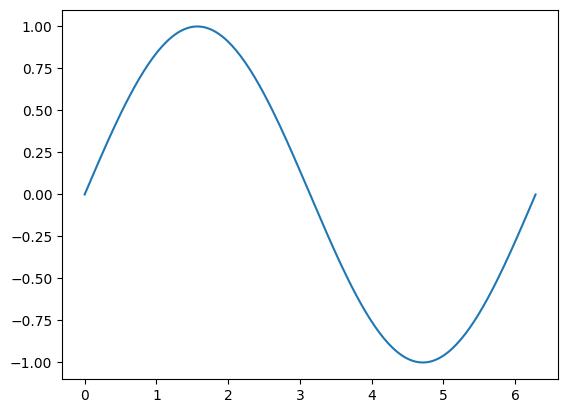

In [46]:
x = torch.linspace(0,2*pi,200).unsqueeze(1)
label = torch.sin(x)
matplotlib.pyplot.plot(x,label)

###Tasks

1. Create a small MLP, `Sin()`, that takes one input, has a single hidden layer with 16 neurons and ReLU activation then an output layer with one output and no activation. This should require only small adaptation from the MLP used in exercise 1.

* First one without sigmoid layer - no need for an activation function.

2. Decide on what loss function to use. The task here is regression not classification (you are predicting a continuous value). So don't use binary cross entropy loss.

* Unbounded regression.

3. Train your model. The training loop will be similar to exercise 1: pass the inputs `x` through your model, get predicted outputs, compare to `label` with your loss function and take a gradient descent step. Keep an eye on the loss value during training. If it's not reducing fast enough, increase learning rate (or try switching to the Adam optimiser). If it's diverging and going crazy, reduce the learning rate.

* Adam leverages past gradient information to accelerate convergence.

4. Once training has converged, plot the output of your network and compare it to the ground truth sinusoid. How well does it approximate the function? Can you see how ReLU is using straight line segments to approximate a curved function?

* In the negative bit, you have a V shape which shows this.

5. Repeat the above but make your network smaller (e.g. reduce the hidden neurons to 8). How good is the approximation now?

* Reduced accurary and it is not as drastic as the previous example.



In [47]:
#1
class Sin(nn.Module):
  def __init__(self):
    super(Sin, self).__init__()

    self.mlp = nn.Sequential(
                  nn.Linear(1,16),
                  nn.ReLU(),
                  nn.Linear(16,1)
    )
  def forward(self, x):
    x = self.mlp(x)
    return x

In [48]:
#2 + 3
model = Sin()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(5000):
  y = model(x)
  # Constrained regression so we have this.
  loss = torch.mean((y-label)**2)
  optim.zero_grad()
  loss.backward()
  optim.step()
  if not epoch % 200:
    print('[{:d}] Loss: {:.4f}'.format(epoch,loss.item()))

[0] Loss: 0.5087
[200] Loss: 0.0569
[400] Loss: 0.0170
[600] Loss: 0.0060
[800] Loss: 0.0053
[1000] Loss: 0.0051
[1200] Loss: 0.0050
[1400] Loss: 0.0048
[1600] Loss: 0.0048
[1800] Loss: 0.0044
[2000] Loss: 0.0041
[2200] Loss: 0.0039
[2400] Loss: 0.0045
[2600] Loss: 0.0036
[2800] Loss: 0.0036
[3000] Loss: 0.0035
[3200] Loss: 0.0034
[3400] Loss: 0.0034
[3600] Loss: 0.0034
[3800] Loss: 0.0034
[4000] Loss: 0.0034
[4200] Loss: 0.0034
[4400] Loss: 0.0038
[4600] Loss: 0.0034
[4800] Loss: 0.0033


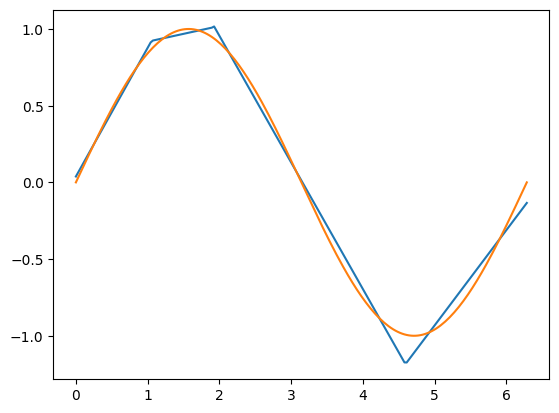

In [49]:
# 4
y = model(x).detach().numpy()
matplotlib.pyplot.plot(x.numpy(),y)
matplotlib.pyplot.plot(x.numpy(),label)

##3. Classifying the spiral dataset

The spiral dataset is a good example of a non-trivial binary classification problem. There are two input features for each data sample: the $x$ and $y$ coordinates of a point. The points belong to one of two classes, depending on which of the two interlocking spirals they lie on. The task is to create a small MLP that takes 2D input

###Generate the spiral dataset

The two classes are points lying on two spirals, rotated by 180 degrees and with some random noise added.

In [50]:
N = 400
training_size = 600
theta = np.sqrt(np.random.rand(N))*2*pi

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

X_train_tensor = torch.from_numpy(np.float32(res[:training_size,0:2]))
Y_train_tensor = torch.from_numpy(np.float32(res[:training_size,2])).unsqueeze(1)
X_test_tensor = torch.from_numpy(np.float32(res[training_size:,0:2]))
Y_test_tensor = torch.from_numpy(np.float32(res[training_size:,2])).unsqueeze(1)

Visualise the dataset by plotting the points in the training set and colouring according to the class.

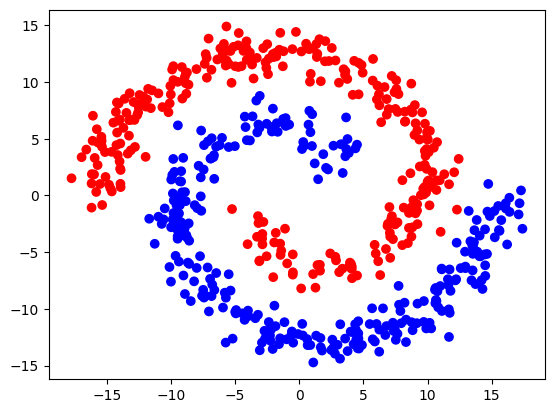

In [51]:
colors = np.where(Y_train_tensor.squeeze(1).numpy() == 0, 'blue', 'red')
matplotlib.pyplot.scatter(X_train_tensor[:,0].numpy(),X_train_tensor[:,1].numpy(),c=colors)
matplotlib.pyplot.show()

As you can see, it would not be possible linearly separate these two classes (you can't draw a straight line that divides the points into the two classes). However, we will see that a very small ReLU MLP can do this perfectly.

###Tasks

1. Instantiate a small classification MLP with 2 inputs, one hidden layer with 16 neurons and sigmoid activation on the output. You can reuse the `MLP()` class from earlier for this.
2. Train the MLP to classify the spiral points into two classes.
3. Evaluate by printing classification performance on training and test sets. Plot the spiral points for the test set as above, but colour them according to the class predicted by your MLP rather than the ground truth labels.
4. Let's visualise what the MLP has actually learnt. For any point in 2D space, the MLP assigns a probability. We can visualise this as an image. Use `torch.meshgrid` to create a grid of points over the range -15..15 in $x$ and $y$. Pass all those points through your model to get probabilities. Display the probabilities as an image using matplotlib's `imshow`. You should be able to see the *decision boundary* i.e. the point where the probability is 0.5 and it is separating the two classes. Can you see the influence of ReLU here?
5. As an extra challenge, try to draw the decision boundary over the top of the image as a contour plot. Hint: `skimage.measure.find_contours` will be helpful here.


In [52]:
#1
spiralModel = MLP(2, 16)

In [53]:
#2
epochs = 5000

# Instantiate loss function (binary cross entropy loss - sigmoid applied inside model)
criterion = torch.nn.BCELoss()
# Setup optimiser
optim = torch.optim.SGD(spiralModel.parameters(), lr=0.1)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = spiralModel(X_train_tensor)
    # Compute BCE loss
    loss = criterion(y_predict,Y_train_tensor)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.8901515603065491
epoch 200, loss 0.44193628430366516
epoch 400, loss 0.33098047971725464
epoch 600, loss 0.31381797790527344
epoch 800, loss 0.2219063639640808
epoch 1000, loss 0.13167768716812134
epoch 1200, loss 0.08771879225969315
epoch 1400, loss 0.06723380088806152
epoch 1600, loss 0.056876856833696365
epoch 1800, loss 0.04945569485425949
epoch 2000, loss 0.04388568550348282
epoch 2200, loss 0.03944326564669609
epoch 2400, loss 0.035816073417663574
epoch 2600, loss 0.032712433487176895
epoch 2800, loss 0.03010852448642254
epoch 3000, loss 0.02783331833779812
epoch 3200, loss 0.025823740288615227
epoch 3400, loss 0.024062084034085274
epoch 3600, loss 0.022492391988635063
epoch 3800, loss 0.021079136058688164
epoch 4000, loss 0.019819600507616997
epoch 4200, loss 0.018678756430745125
epoch 4400, loss 0.017545878887176514
epoch 4600, loss 0.016425183042883873
epoch 4800, loss 0.015260109677910805


In [55]:
# 3
# Pass training set set through model
y_predict = spiralModel(X_train_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_train_tensor).float().sum()
print("Percent training set correctly classified: {:.2f}%".format(100*correct/training_size))

# Pass test set through model
y_predict = spiralModel(X_test_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_test_tensor).float().sum()
print("Percent test set correctly classified: {:.2f}%".format(100*correct/X_test_tensor.shape[0]))

Percent training set correctly classified: 99.83%
Percent test set correctly classified: 99.50%


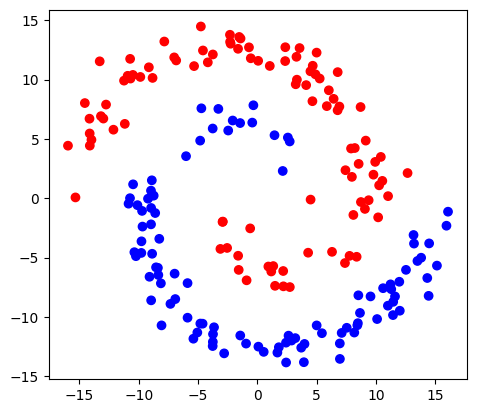

In [56]:
# Just get the numpy value -> split them into blue and green
colors = np.where(y_predict.squeeze(1).detach().numpy() < 0.5, 'blue', 'red')
matplotlib.pyplot.scatter(X_test_tensor[:,0].numpy(),X_test_tensor[:,1].numpy(),c=colors)
ax = matplotlib.pyplot.gca()
ax.set_aspect('equal', adjustable='box')
matplotlib.pyplot.show()

[]

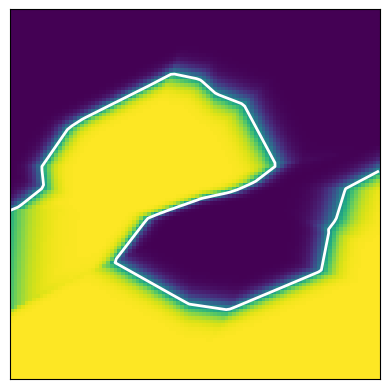

In [70]:
#4
from skimage import measure

# Choose a resolution for the image - I will use 100x100 pixels
res = 100
# Create a 100x100 grid for x and y going from -15 to 15
xs = torch.linspace(15, -15, steps=res)
ys = torch.linspace(-15, 15, steps=res)
# Duplicate sequence over the same number of lines
# Both of shape: (100, 100), duplicates the sequence over the 100 rows.
X, Y = torch.meshgrid(xs, ys, indexing='xy')

# X and Y have size 100x100. We need to concatenate to create 2D channel input for the network.
# However, this would end up with something sized 100x100x2 whereas the network will only accept
# batch x 2. So, we need to flatten along the first two dimensions. This can be done with either
# reshape or flatten.
# Going from an 100x100 to a 200x1 - just put everything on one row.
x=torch.cat((X.reshape(res**2,1),Y.reshape(res**2,1)),dim=1)
# Or equivalently:
# x=torch.cat((X.flatten().unsqueeze(1),Y.flatten().unsqueeze(1)),dim=1)

# Pass the grid of points through the trained model, then reshape back to 100x100
# The detach and numpy calls are needed to prepare the output to be passed to matplotlib.
# Put it through the model in with 2 inputs as expected, then redo it to a 100 x 100 grid.
# The probabilities that our model provides, in a graph format.
p = spiralModel(x).reshape(res,res).detach().numpy()

# We can find the location of the decision boundary (places were p=0.5) using find_contours
contours = measure.find_contours(p, 0.5)

# Display the image
fig, ax = matplotlib.pyplot.subplots()
ax.imshow(p)

# Overlay the contours
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='white')

ax.set_xticks([])
ax.set_yticks([])